# 3 Construct overall data-balanced RAFDB dataset 
# (for object detection)

### This section focuses on solving the data imbalance problem of RAF-DB.
#### In the following code block, multiple data augmentation methods are used to increase the number of categories in each of the original RAFDB target detection datasets to the number of categories with the highest sample size. Then divide the dataset according to 7:2:1.

In [7]:
import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
import albumentations as A

emotions = ['surprise', 'fear', 'disgust', 'happiness', 'sadness', 'anger', 'neutral']
TARGET_COUNT = 8000
IMAGE_DIR = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB-detection(images+labels)/original'
LABEL_DIR = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB-detection(images+labels)/RAFDB_all_labels'
AUGMENTED_IMAGE_DIR = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_Detection_balance/images'
AUGMENTED_LABEL_DIR = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_Detection_balance/labels'

os.makedirs(AUGMENTED_IMAGE_DIR, exist_ok=True)
os.makedirs(AUGMENTED_LABEL_DIR, exist_ok=True)

image_files = glob(os.path.join(IMAGE_DIR, '*.jpg'))
label_files = glob(os.path.join(LABEL_DIR, '*.txt'))

category_counts = {emotion: 0 for emotion in emotions}
single_category_files = {emotion: [] for emotion in emotions}

for label_file in label_files:
    with open(label_file, 'r') as file:
        lines = file.readlines()
        if len(lines) == 1:
            category_idx = int(lines[0].split()[0])
            category = emotions[category_idx]
            image_file = label_file.replace(LABEL_DIR, IMAGE_DIR).replace('.txt', '.jpg')
            single_category_files[category].append((image_file, label_file))
        for line in lines:
            category_idx = int(line.split()[0])
            category = emotions[category_idx]
            category_counts[category] += 1
print("Initial category counts:")
for category, count in category_counts.items():
    print(f"{category}: {count} instances")

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.Rotate(limit=(5,10), p=0.5),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5)  
])

for image_file in image_files:
    shutil.copy(image_file, AUGMENTED_IMAGE_DIR)

for label_file in label_files:
    shutil.copy(label_file, AUGMENTED_LABEL_DIR)

total_augmentations_needed = sum(max(0, TARGET_COUNT - count) for count in category_counts.values())

print("\nStarting data augmentation...")
with tqdm(total=total_augmentations_needed, unit=' instances') as pbar:
    for category, files in single_category_files.items():
        while category_counts[category] < TARGET_COUNT:
            for image_file, label_file in files:
                if category_counts[category] >= TARGET_COUNT:
                    break
                image = cv2.imread(image_file)
                augmented = transform(image=image)
                augmented_image = augmented['image']
                base_name = os.path.basename(image_file)
                augmented_image_file = os.path.join(AUGMENTED_IMAGE_DIR, f'{category}_{category_counts[category]}_{base_name}')
                augmented_label_file = os.path.join(AUGMENTED_LABEL_DIR, f'{category}_{category_counts[category]}_{os.path.basename(label_file)}')
                cv2.imwrite(augmented_image_file, augmented_image)
                shutil.copy(label_file, augmented_label_file)
                category_counts[category] += 1
                pbar.update(1)

print("\nAugmented category counts:")
for category, count in category_counts.items():
    print(f"{category}: {count} instances")

print("\nData augmentation completed!")


Initial category counts:
surprise: 1780 instances
fear: 452 instances
disgust: 1008 instances
happiness: 7325 instances
sadness: 2584 instances
anger: 937 instances
neutral: 3625 instances

Starting data augmentation...


100%|██████████| 38289/38289 [05:08<00:00, 123.97 instances/s]


Augmented category counts:
surprise: 8000 instances
fear: 8000 instances
disgust: 8000 instances
happiness: 8000 instances
sadness: 8000 instances
anger: 8000 instances
neutral: 8000 instances

Data augmentation completed!


### Show the balanced data set
#### The number and distribution of validation and test sets remain unchanged from the original RAF-DB-Detection dataset.

In [1]:
import os
import matplotlib.pyplot as plt

def analyze_yolo_dataset_total(dataset_path, dataset_name):
    emotions = ['surprise', 'fear', 'disgust', 'happiness', 'sadness', 'anger', 'neutral']
    emotion_counts = {emotion: 0 for emotion in emotions}
    txt_file_count = 0

    for root, _, files in os.walk(dataset_path):
        for file_name in files:
            if file_name.endswith('.txt'):
                txt_file_count += 1  
                txt_file_path = os.path.join(root, file_name)
                
                try:
                    with open(txt_file_path, 'r') as file:
                        lines = file.readlines()
                        for line in lines:
                            emotion_id = int(line.split()[0])
                            emotion = emotions[emotion_id]
                            emotion_counts[emotion] += 1
                except Exception as e:
                    print(f"Error reading file {file_name}: {e}")
                    continue
    for emotion, count in emotion_counts.items():
        print(f'{emotion}: {count} instances')

    print(f'Total number of txt files read: {txt_file_count}')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    wedges, texts, autotexts = ax1.pie(emotion_counts.values(), labels=emotion_counts.keys(), autopct='%1.1f%%', startangle=140)
    ax1.set_title(f'Distribution of Emotions in {dataset_name}', fontweight='bold', fontsize=14)
    ax1.axis('equal') 

    for text in texts + autotexts:
        text.set_fontsize(17)
        text.set_fontweight('bold')

    bars = ax2.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue')
    ax2.set_xlabel('Emotions', fontweight='bold', fontsize=17)
    ax2.set_ylabel('Number of Instances', fontweight='bold', fontsize=17)
    ax2.set_title(f'Number of Instances for Each Emotion in {dataset_name}', fontweight='bold', fontsize=14)

    for bar in bars:
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontweight='bold', fontsize=17)

    ax2.tick_params(axis='x', labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)

    plt.show()


surprise: 8000 instances
fear: 8000 instances
disgust: 8000 instances
happiness: 8000 instances
sadness: 8000 instances
anger: 8000 instances
neutral: 8000 instances
Total number of txt files read: 53628


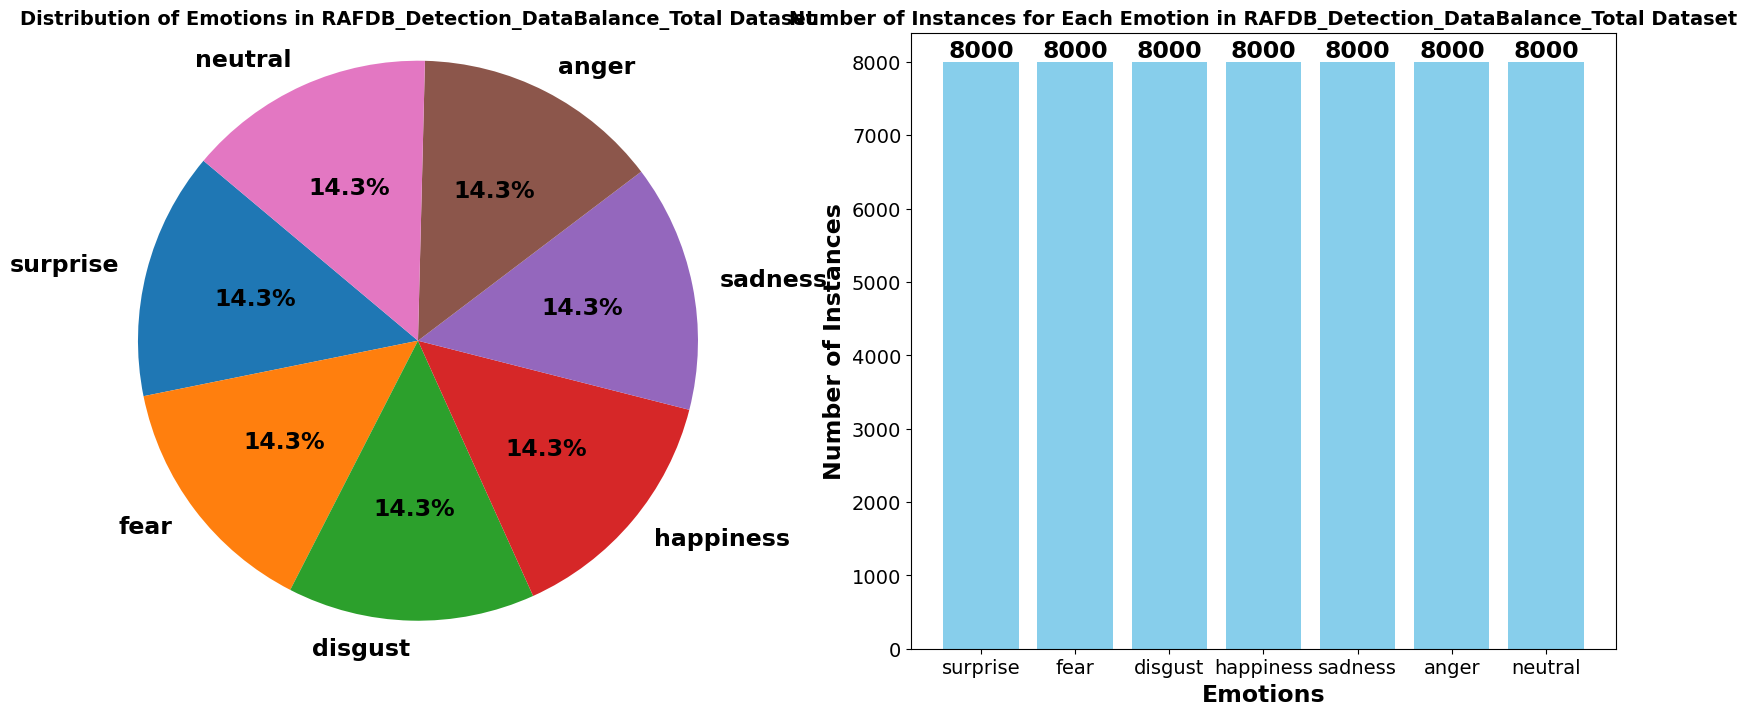

In [2]:
# RAFDB_Detection_balance_Total Dataset
dataset_path = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_YOLO_detection_databalance'
dataset_name = 'RAFDB_Detection_DataBalance_Total Dataset'
analyze_yolo_dataset_total(dataset_path, dataset_name)

### Check if the labels correspond to the images

In [11]:

import os

def get_filenames_without_extension(directory, extensions):
    return set(os.path.splitext(f)[0] for f in os.listdir(directory) if f.endswith(extensions))

def find_mismatched_files(image_dir, text_dir):
    image_files = get_filenames_without_extension(image_dir, ('.jpg', '.jpeg', '.png'))
    text_files = get_filenames_without_extension(text_dir, '.txt')
    
    images_without_texts = image_files - text_files
    texts_without_images = text_files - image_files
    
    return images_without_texts, texts_without_images

image_directory = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_Detection_balance/images'
text_directory = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_Detection_balance/labels'

images_without_texts, texts_without_images = find_mismatched_files(image_directory, text_directory)

if not images_without_texts and not texts_without_images:
    print("All images and txt files correspond one to one.")
else:
    if images_without_texts:
        print("There is no image corresponding to the txt file:")
        for image in images_without_texts:
            print(image)

    if texts_without_images:
        print("\nThere is no txt file that corresponds to the image:")
        for text in texts_without_images:
            print(text)


All images and txt files correspond one to one.


### Test label accuracy by output

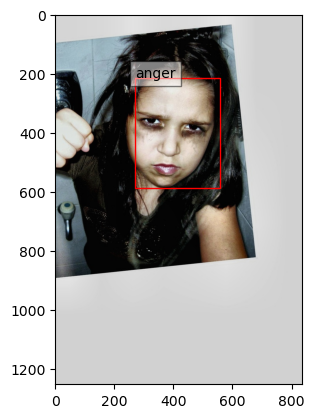

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

classes = ['surprise', 'fear', 'disgust', 'happiness', 'sadness', 'anger', 'neutral']

image_path = r'/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_Detection_balance/images/anger_1115_train_00647.jpg'
img = Image.open(image_path)
label_path = r'/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_Detection_balance/labels/anger_1115_train_00647.txt'
with open(label_path, 'r') as f:
    labels = f.readlines()

fig, ax = plt.subplots(1)
ax.imshow(img)
width, height = img.size

for label in labels:
    parts = label.strip().split()
    class_id = int(parts[0])
    x_center = float(parts[1]) * width
    y_center = float(parts[2]) * height
    bbox_width = float(parts[3]) * width
    bbox_height = float(parts[4]) * height
    
    xmin = x_center - bbox_width / 2
    ymin = y_center - bbox_height / 2
    
    rect = patches.Rectangle((xmin, ymin), bbox_width, bbox_height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(xmin, ymin, classes[class_id], bbox=dict(facecolor='white', alpha=0.5))

plt.show()

### Split the RAFDB-YOLO-Detection dataset according to 7:2:1

In [14]:
import os
import shutil
import random

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def move_files(file_list, src_img_dir, src_lbl_dir, dst_img_dir, dst_lbl_dir):
    for file in file_list:
        img_path = os.path.join(src_img_dir, file)
        lbl_path = os.path.join(src_lbl_dir, file.replace('.jpg', '.txt').replace('.png', '.txt'))

        if os.path.exists(img_path) and os.path.exists(lbl_path):
            shutil.move(img_path, dst_img_dir)
            shutil.move(lbl_path, dst_lbl_dir)

def split_dataset(img_dir, lbl_dir, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1):
    images = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]
    random.shuffle(images)

    total_count = len(images)
    train_count = int(total_count * train_ratio)
    valid_count = int(total_count * valid_ratio)

    train_files = images[:train_count]
    valid_files = images[train_count:train_count + valid_count]
    test_files = images[train_count + valid_count:]

    return train_files, valid_files, test_files

def main():
    img_dir = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_Detection_balance/images'
    lbl_dir = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_Detection_balance/labels'

    train_img_dir = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_YOLO_detection_databalance/train/images'
    train_lbl_dir = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_YOLO_detection_databalance/train/labels'
    valid_img_dir = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_YOLO_detection_databalance/valid/images'
    valid_lbl_dir = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_YOLO_detection_databalance/valid/labels'
    test_img_dir = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_YOLO_detection_databalance/test/images'
    test_lbl_dir = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_YOLO_detection_databalance/test/labels'

    create_dir(train_img_dir)
    create_dir(train_lbl_dir)
    create_dir(valid_img_dir)
    create_dir(valid_lbl_dir)
    create_dir(test_img_dir)
    create_dir(test_lbl_dir)


    train_files, valid_files, test_files = split_dataset(img_dir, lbl_dir)
    move_files(train_files, img_dir, lbl_dir, train_img_dir, train_lbl_dir)
    move_files(valid_files, img_dir, lbl_dir, valid_img_dir, valid_lbl_dir)
    move_files(test_files, img_dir, lbl_dir, test_img_dir, test_lbl_dir)

    print("Completion of dataset partitioning!")

if __name__ == '__main__':
    main()


Completion of dataset partitioning!


### Display datasets information

surprise: 8000 instances
fear: 8000 instances
disgust: 8000 instances
happiness: 8000 instances
sadness: 8000 instances
anger: 8000 instances
neutral: 8000 instances
Total number of txt files read: 53628


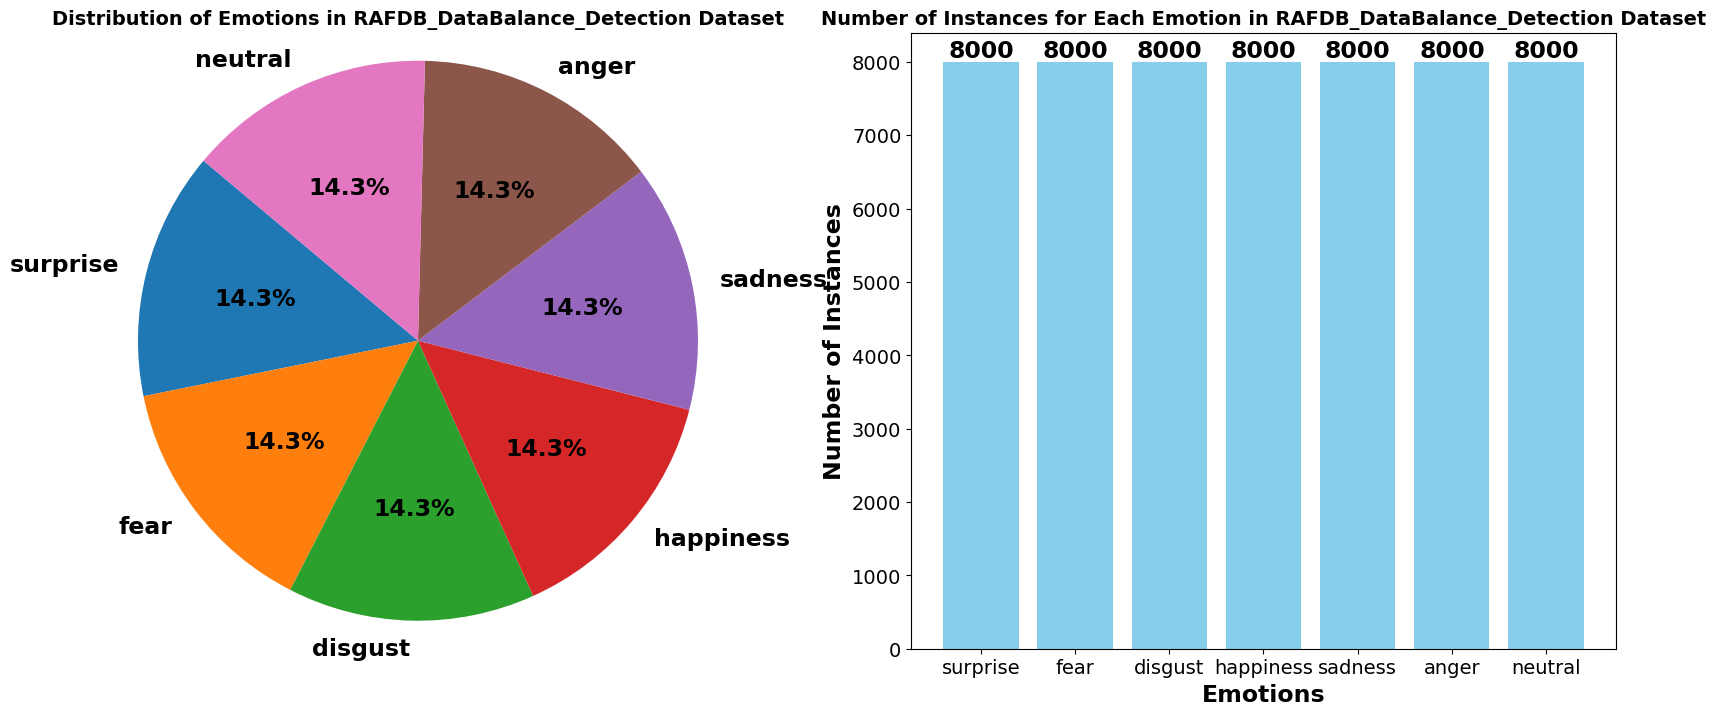

In [5]:
# RAFDB_DataBalance_Detection Dataset
dataset_path = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_YOLO_detection_databalance'
dataset_name = 'RAFDB_DataBalance_Detection Dataset'
analyze_yolo_dataset_total(dataset_path, dataset_name)

surprise: 5602 instances
fear: 5591 instances
disgust: 5528 instances
happiness: 5552 instances
sadness: 5672 instances
anger: 5594 instances
neutral: 5636 instances
Total number of txt files read: 37539


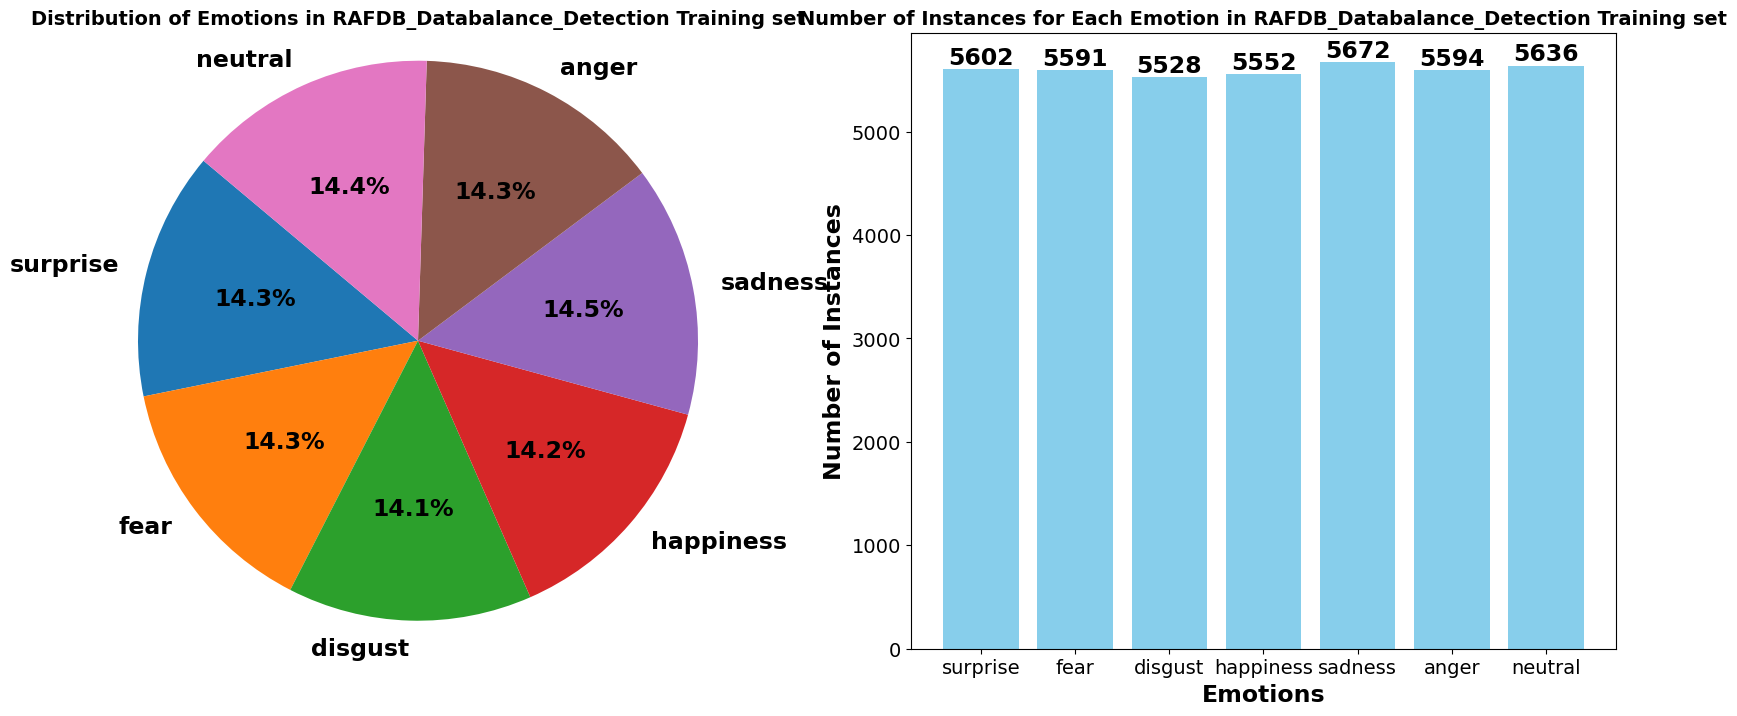

In [7]:
# RAFDB_Databalance_Detection Training_set
dataset_path = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_YOLO_detection_databalance/train'
dataset_name = 'RAFDB_Databalance_Detection Training set'
analyze_yolo_dataset_total(dataset_path, dataset_name)

surprise: 1595 instances
fear: 1627 instances
disgust: 1634 instances
happiness: 1650 instances
sadness: 1553 instances
anger: 1600 instances
neutral: 1574 instances
Total number of txt files read: 10725


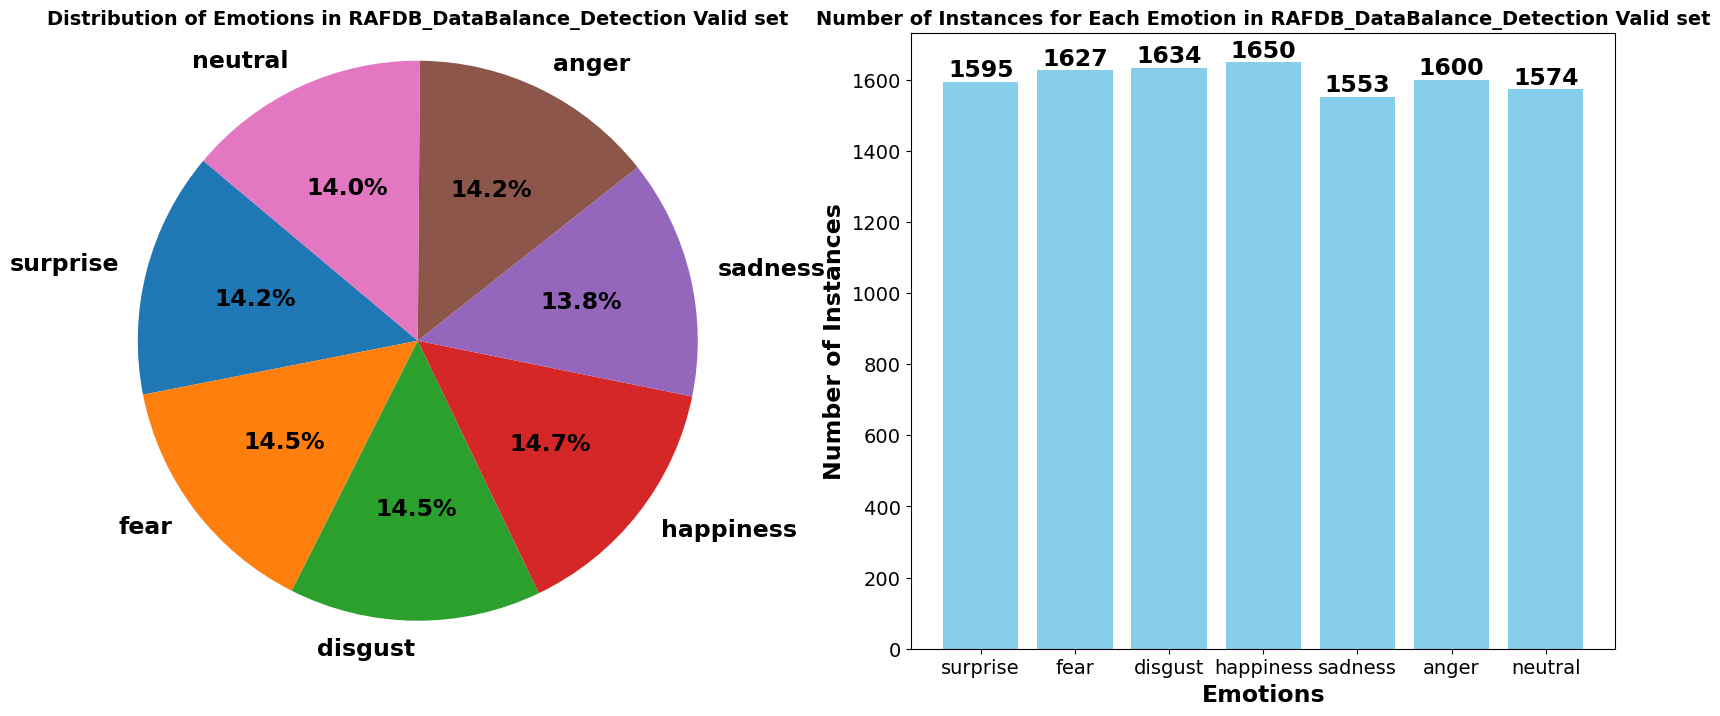

In [8]:
# RAFDB_DataBalance_Detection Validation set
dataset_path = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_YOLO_detection_databalance/valid'
dataset_name = 'RAFDB_DataBalance_Detection Valid set'
analyze_yolo_dataset_total(dataset_path, dataset_name)

surprise: 803 instances
fear: 782 instances
disgust: 838 instances
happiness: 798 instances
sadness: 775 instances
anger: 806 instances
neutral: 790 instances
Total number of txt files read: 5364


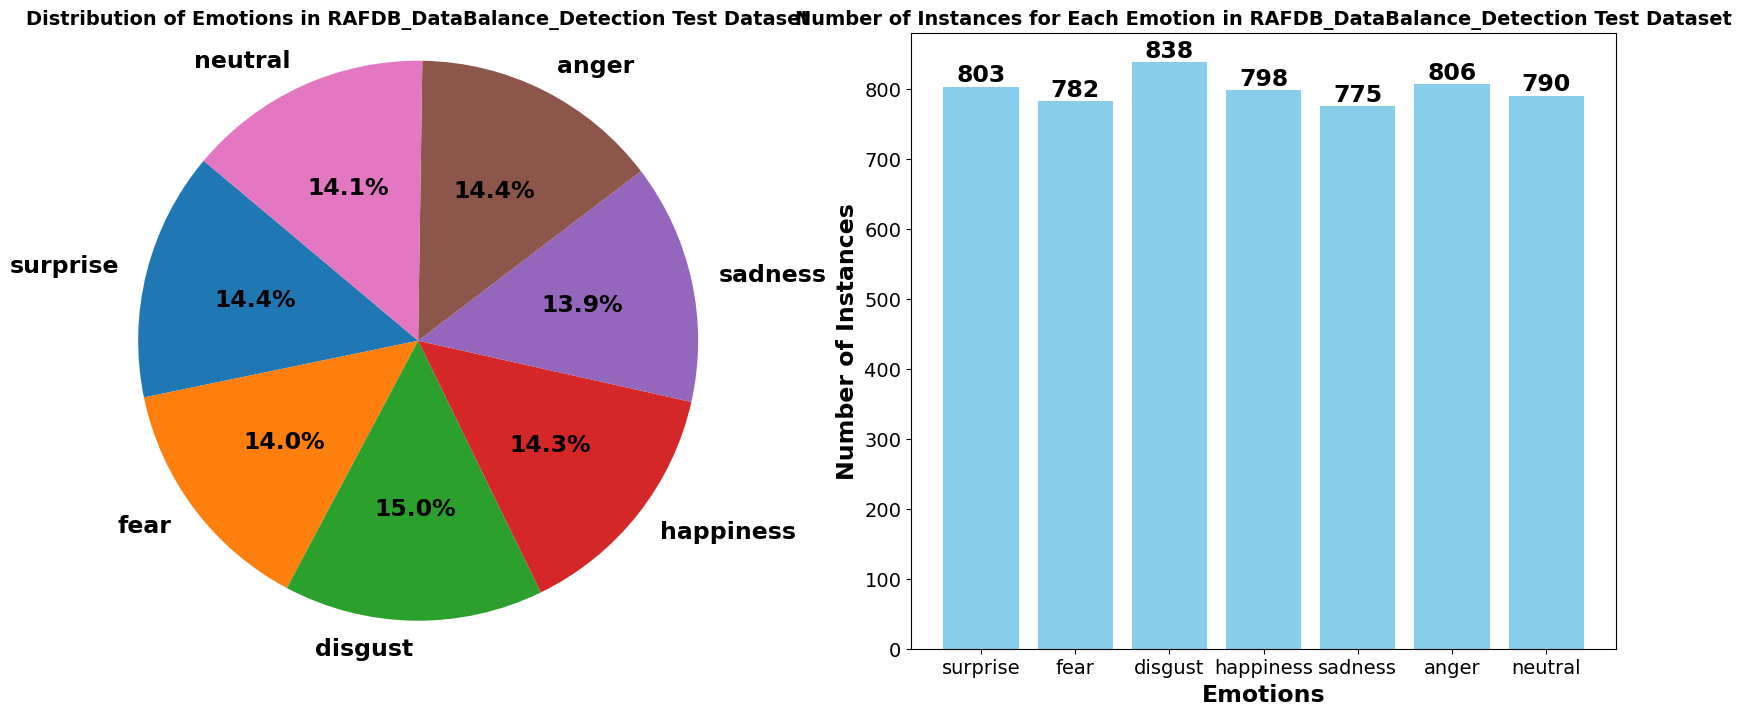

In [9]:
# RAFDB_Datalance_Detection Test set
dataset_path = '/Users/piglet/Desktop/Project_Code/RAFDB/workspace/RAFDB_YOLO_detection_databalance/test'
dataset_name = 'RAFDB_DataBalance_Detection Test Dataset'
analyze_yolo_dataset_total(dataset_path, dataset_name)